Micrograd Scratchpad

In [155]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random 
%matplotlib inline


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

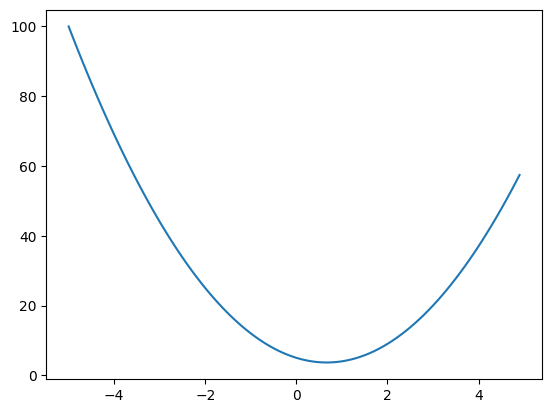

In [10]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys)

In [14]:
# defintion of a derivative
h = 0.0001

#inputs 
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c+=h
d2 = a*b + c

print("d1,", d1)
print("d2,", d2)
print("slope,", (d2-d1)/h)



d1, 4.0
d2, 4.0001
slope, 0.9999999999976694


In [136]:
# basic data structure to maintain mathematical expressions
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0                 # default assume no effect on loss function
        self._backward = lambda: None   # store function of how to chain output gradient into input gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # basically toString method
    def __repr__(self):
        return f"Value(data={self.data})"
  
    # override default __add__ operator function
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # wrap any int with Value
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad   # local derivative * "global" derivative (output), wrt output
            other.grad += 1.0 * out.grad  # why are these accumulative (+=) not equal (=)? Because if we use same variable, it overrides previously computed gradients 
        out._backward = _backward   # NOTE: no function call() because we are trying to save the function not the output
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    # NOTE: if __mul__ fails, then python will automatically try __rmul__, for cases like a*2 == 2*a
    def __rmul__(self, other): # other * self
        return self * other

    # =========== Implement division ===========
    # NOTE: a/b is a*(1/b) which is also a*(b**-1)
    # Goal: Implement x**k, k is constant
    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    
    # We can use any function as long as we know how to differentiate it (they can be complex or simple)
    # If we know derivative of function, we can backpropagate through it
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
        
        return out
    
    
    def backward(self):
        # Topological Sort (see cell below)
        topo = []
        visited = set()
        def build_topo(v):  # we start at output o node
            if v not in visited:
                visited.add(v)
                for child in v._prev:   # add all children first
                    build_topo(child)
                topo.append(v)          # add self last
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo): # topological sort returns list with children first, root node last --> need to reverse
            node._backward()

# a = Value(2.0, label = 'a')
# b = Value(-3.0, label = 'b')
# c = Value(10.0, label = 'c')
# e = a*b; e.label = 'e'
# d = e + c; d.label = 'd'

# # print("d =", d)
# # print("parents of d:", d._prev)
# # print("operator to make d:", d._op)

# f = Value(-2.0, label = 'f')
# L = d*f; L.label = 'L'


In [84]:
# Visualization tool for computing gradients
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

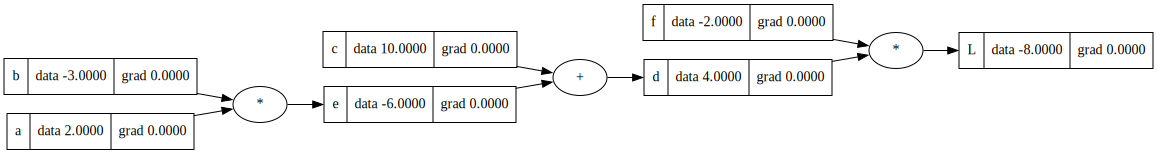

In [85]:
# build out forward pass of mathematical expression
draw_dot(L)

Backpropagation would just be finding the derivatives of each of the nodes with respect to the result (or in other words, the derivative of the loss function with respect to the weights of the neural network)

Need a variable within Value that will store derivative of L with respect to the node (grad)

In [125]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

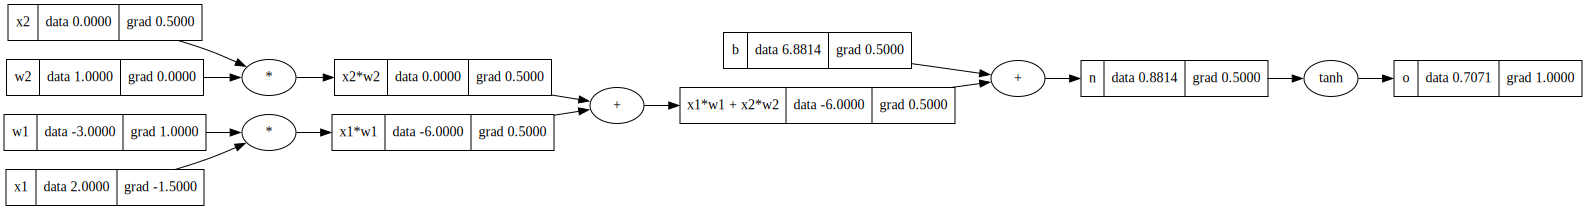

In [128]:
draw_dot(o)

In [127]:
# Manually Calling Backwards Function 
o.grad = 1.0
o._backward()

n._backward()

b._backward() # does nothing cause leaf node

x1w1x2w2._backward()

x2w2._backward()
x1w1._backward()

Backpropagation Outline
- Call _backward() on a node only after all dependencies are computed (i.e. nodes after it)
  - **use topological sort to obtain ordering**
  n._backward()

In [52]:
# # Topological Sort Implementation
# o.grad = 1.0 # initialize o, always 

# topo = []
# visited = set()
# def build_topo(v): # we start at output o node
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:   # add all children first
#       build_topo(child)    
#     topo.append(v)          # add self last 
# build_topo(o)

# for node in reversed(topo): # topological sort returns list with children first, root node last --> need to reverse
#     node._backward()

In [57]:
o.backward()

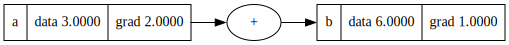

In [129]:
# Fixing the multivariate bug 
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

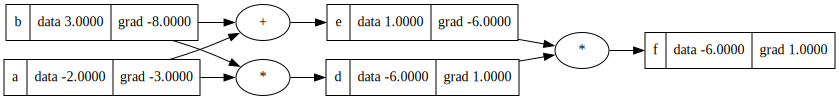

In [130]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

Breaking tanh complex function into atomic functions (for exercise)

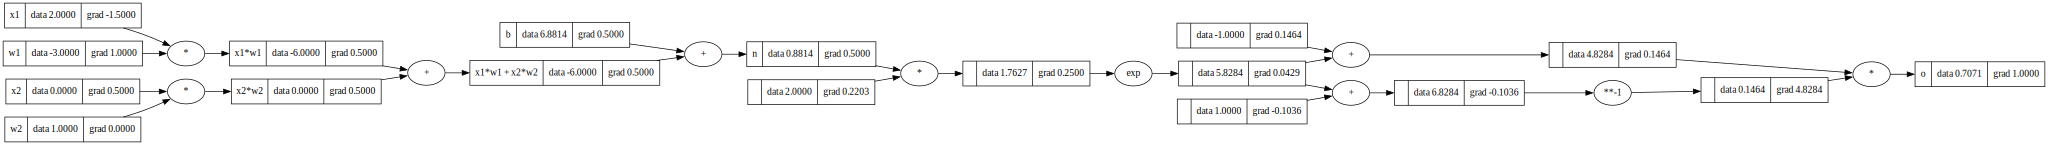

In [137]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
##################################
# Redefine tanh by e^2x-1 / e^2x+1
e = (2*n).exp()
o = (e-1) / (e+1); o.label = 'o'
##################################
o.backward()
draw_dot(o)

PyTorch Method
- Scalars (Micrograd) --> Tensors (PyTorch, n-dimensional arrays of scalars)
- Layer of neurons is a set of neurons fully connected to the previous layer and evaluated independently of other neurons in the layer

In [190]:
import torch 

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True # NOTE: these default to false for efficiency (leaf nodes)
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [191]:
torch.Tensor([[1,2,3],[4,5,6]]).dtype # NOTE: defaults to float32, cast to double for float64 (python default)


torch.float32

In [192]:
class Neuron:
  
    def __init__(self, nin):  # initialize random weight and bias for every input - nin
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # NOTE: sum takes in a secondary argument as starting number (+self.b)
        out = act.tanh()
        return out
  
# x = [2.0,3.0]
# n = Neuron(2)
# n(x)
    def parameters(self): # return list of parameter scalars
        return self.w + [self.b]

class Layer:
  
    def __init__(self, nin, nout):    # nout: number of neurons in layer
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
# x = [2.0,3.0]
# n = Layer(2, 3)
# n(x)

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        '''
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
        '''
  
class MLP:
  
    def __init__(self, nin, nouts):   # nout: list of sizes of each layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

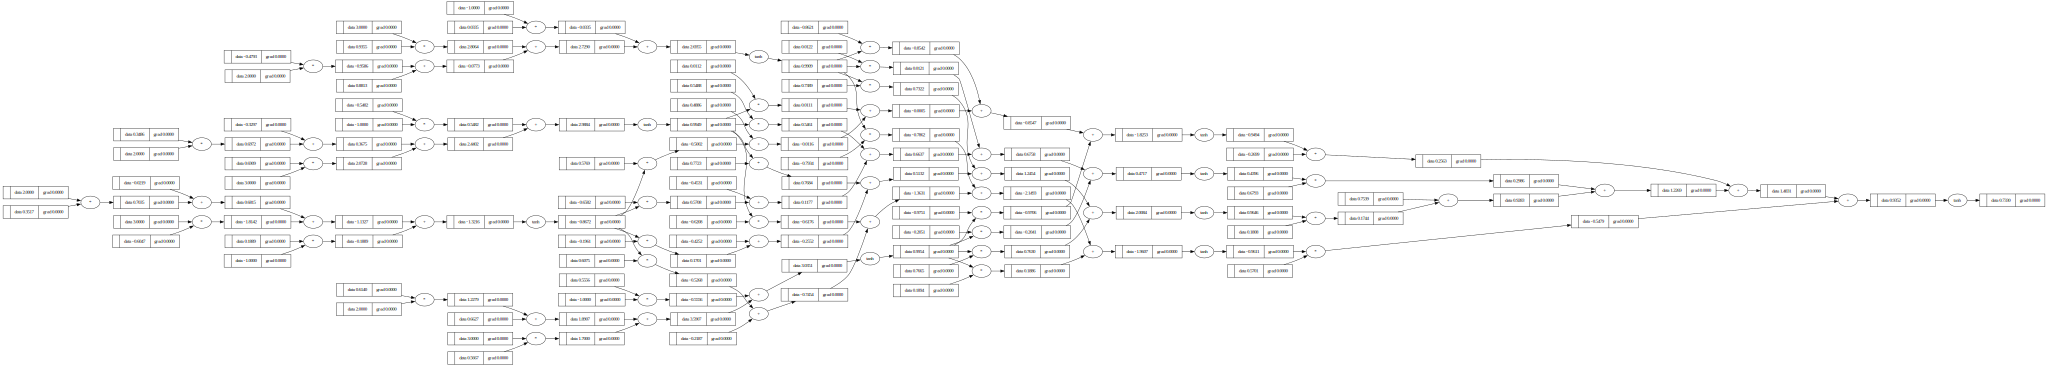

In [194]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
draw_dot(n(x))

In [195]:
# Sample dataset xs[i] --> binary classifier result ys[i]
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7330094202832123),
 Value(data=0.34294266915962573),
 Value(data=0.39563719600511504),
 Value(data=0.6208998181546542)]

In the above example dataset, we want the y-predictions to be mapped correctly to the ys labels. Currently, the outputs are nowhere near so we need a single number that can measure total performance of neural network --> Loss.  

For gradient descent, think of gradient as vector pointing in direction of increased loss; we will modify each parameter by a small step-size increment in direction of this gradient. Goal is to minimize loss.
- Forward pass
- Backward pass
- Update parameters
- Repeat

In [196]:
# Training Loop for Gradient Descent
# MSE Loss
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # NOTE: necessary step to reset gradient to 0, else it continues to accumulate
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad # negative to minimize loss
  
  print(k, loss.data)

0 3.966299113055281
1 2.282557883795822
2 1.3115762742103603
3 0.8615476970972561
4 0.603294365692846
5 0.44468977401067317
6 0.3428620248306931
7 0.27435325426920987
8 0.22616735372702365
9 0.19092986975931103
10 0.16429581521951106
11 0.14359782231496315
12 0.12713260614740649
13 0.11377285572924122
14 0.10274832962230171
15 0.09351776881825205
16 0.08569129781852802
17 0.07898188557350494
18 0.0731740894621112
19 0.06810339370595817


In [197]:
ypred

[Value(data=0.9247000956801481),
 Value(data=-0.9189439598524691),
 Value(data=-0.8068251588271456),
 Value(data=0.8638136673200146)]

## Common Mistake 
- Dont forgot to .zero_grad() in pytorch before .backward()